In [55]:
class InformationAgent(Agent):
    """ An agent with a grid. """
    def __init__(self, unique_id, model, initial_grid, error_rate):
        super().__init__(unique_id, model)
        self.grid_size = initial_grid.shape[0]
        self.error_rate = error_rate
        # Initialize grid with the provided initial grid and introduce errors
        self.grid = self._introduce_errors(initial_grid)

    def _introduce_errors(self, grid):
        """ Introduce random errors into the grid based on error_rate. """
        num_cells = grid.size
        num_errors = int(num_cells * self.error_rate)
        error_indices = np.random.choice(num_cells, num_errors, replace=False)
        flat_grid = grid.flatten()
        flat_grid[error_indices] = 1 - flat_grid[error_indices]  # Flip the values
        return flat_grid.reshape(self.grid_size, self.grid_size)

    def step(self):
        """ Agent takes a step in the simulation. """
        # Choose two random neighbors
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        if len(neighbors) < 2:
            return  # Not enough neighbors to proceed

        # Choose two random neighbors
        neighbor1, neighbor2 = self.random.sample(neighbors, 2)
        
        # Extract grids
        grid1 = neighbor1.grid
        grid2 = neighbor2.grid
        
        # Find the majority grid
        majority_grid = np.where((grid1 + grid2) >= 1, 1, 0)
        
        # Update the grids of both agents to the majority grid
        self.grid = majority_grid
        neighbor1.grid = majority_grid
        neighbor2.grid = majority_grid


In [56]:
class InformationSpreadModel(Model):
    """ Model to simulate the spread of information. """
    def __init__(self, N, width, height, error_rate, initial_grid):
        self.num_agents = N
        self.grid_size = width
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.original_grid = initial_grid
        self.avg_grids = []
        self.steps_taken = 0

        # Create agents
        for i in range(self.num_agents):
            a = InformationAgent(i, self, self.original_grid, error_rate)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            self.schedule.add(a)

    def step(self):
        self.schedule.step()
        self._record_average_grid()
        self.steps_taken += 1

    def _record_average_grid(self):
        """ Record the average grid at the current step. """
        grids = [agent.grid for agent in self.schedule.agents]
        avg_grid = np.mean(grids, axis=0)
        self.avg_grids.append(avg_grid)

    def plot_results(self):
        """ Plot the average grids and the original grid. """
        num_steps = len(self.avg_grids)
        
        # Determine layout for subplots
        cols = 10  # Number of columns in the subplot grid
        rows = (num_steps + cols - 1) // cols  # Number of rows needed
    
        # Create a new figure
        plt.figure(figsize=(15, rows * 5))
    
        # Plot the original grid once
        plt.subplot(rows, cols + 1, 1)
        plt.imshow(self.original_grid, cmap="binary")
        plt.title("Original Grid")
    
        # Plot average grids for each step
        for i, avg_grid in enumerate(self.avg_grids):
            plt.subplot(rows, cols + 1, i + 2)
            plt.imshow(avg_grid, cmap="binary")
            plt.title(f"Step {i + 1}")
    
        # Adjust the spacing between subplots
        plt.subplots_adjust(left=0.05, right=0.95, top=0.4, bottom=0.05, wspace=0.2, hspace=0.2)
    
        plt.show()



    def plot_network(self):
        """ Function to plot the network of agent connections as a complete network. """
        G = nx.Graph()

        # Add nodes with positions
        for agent in self.schedule.agents:
            G.add_node(agent.unique_id, pos=agent.pos)
        
        # Add edges to create a complete network
        for i, agent in enumerate(self.schedule.agents):
            for j in range(i + 1, len(self.schedule.agents)):
                neighbor = self.schedule.agents[j]
                G.add_edge(agent.unique_id, neighbor.unique_id)

        # Print edge list for debugging
        print("Edges in the network:", G.edges())
        
        # Get positions for all nodes
        pos = {agent.unique_id: agent.pos for agent in self.schedule.agents}

        # Draw the network
        plt.figure(figsize=(10, 10))
        nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='gray', font_size=16, font_weight='bold')
        plt.title('Agent Network (Complete)')
        plt.show()


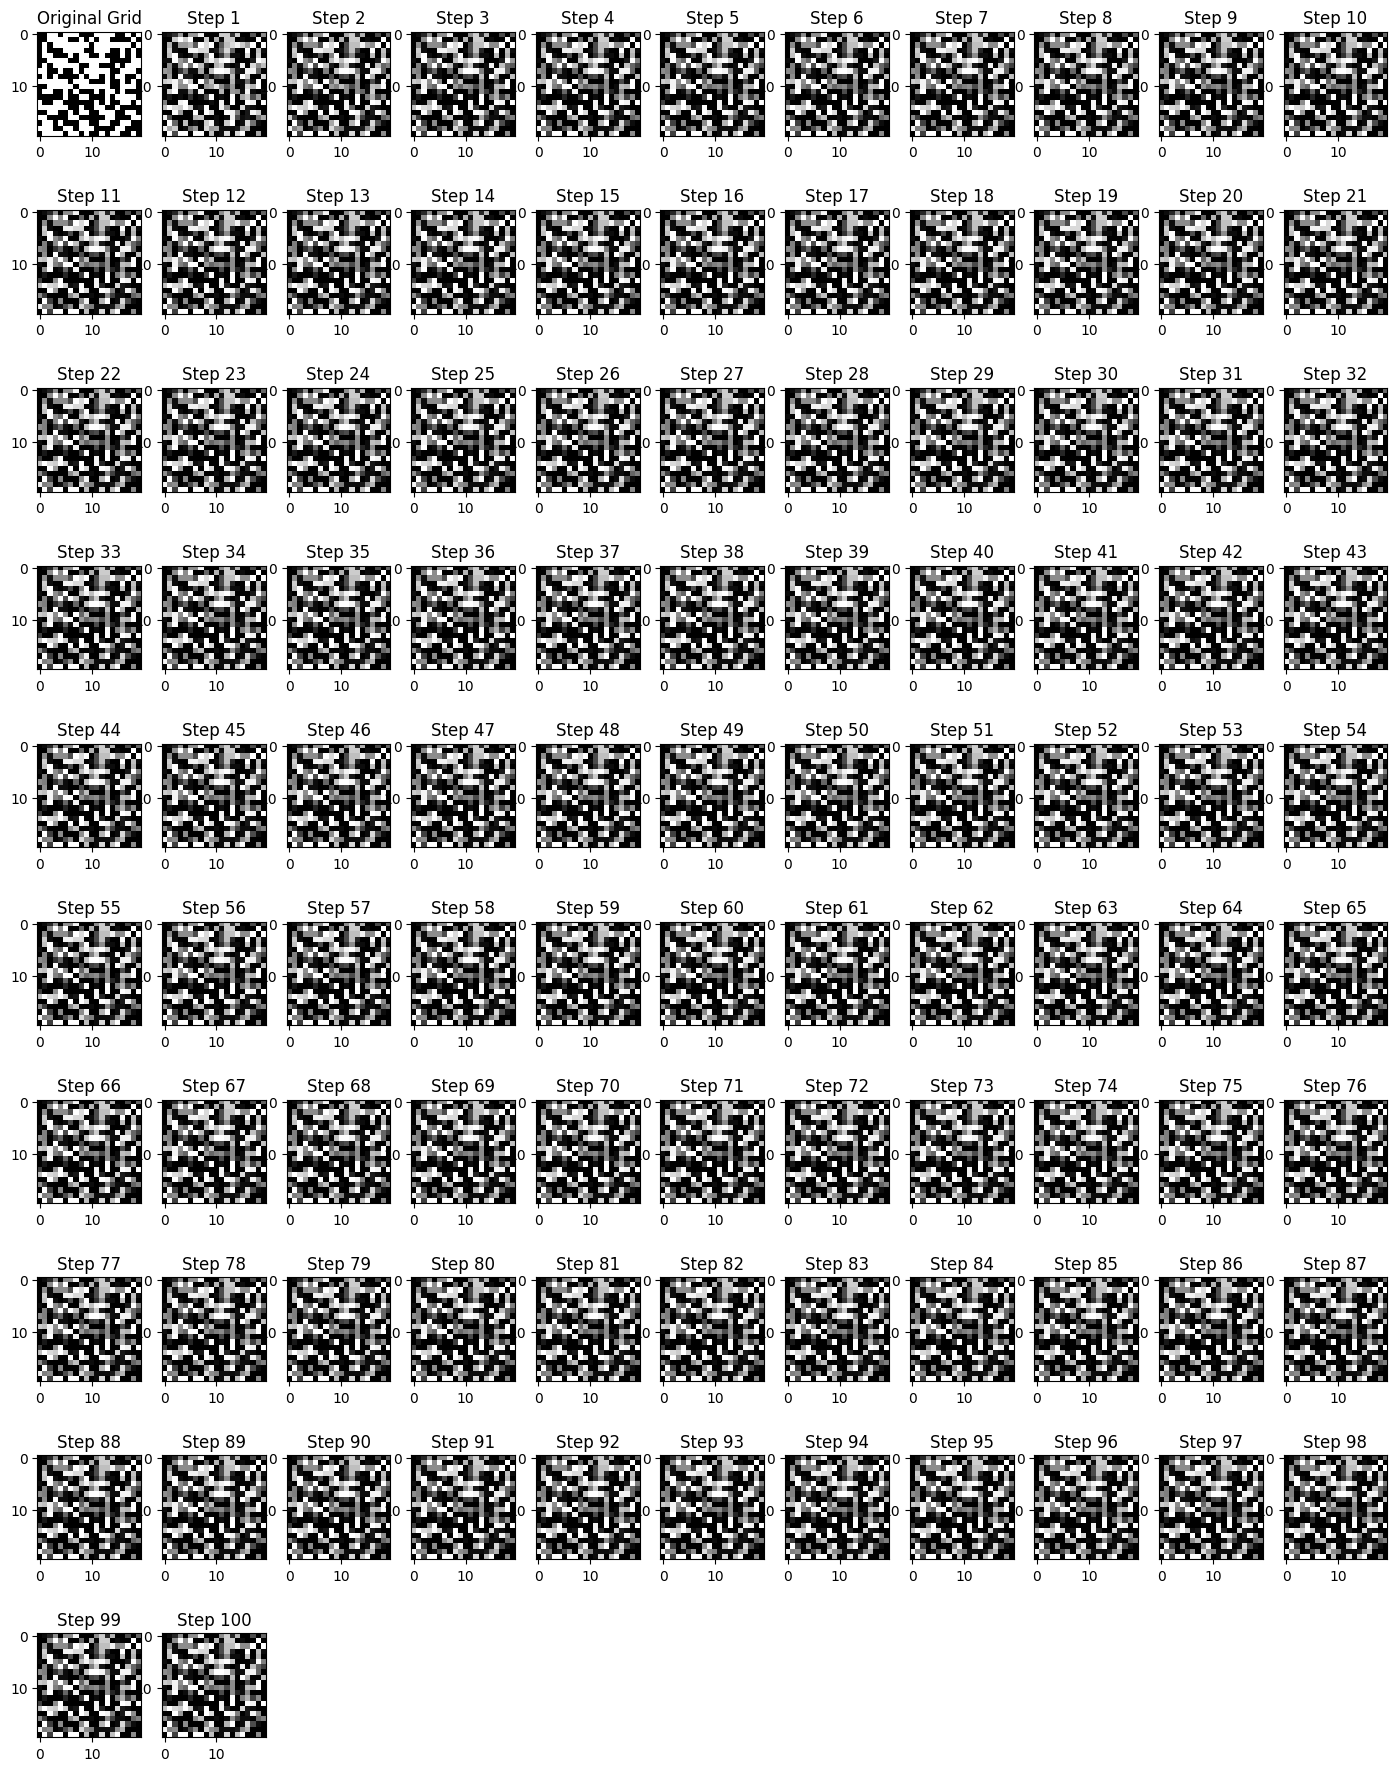

In [57]:
# Define the initial grid
initial_grid = np.random.randint(0, 2, size=(20, 20))  # Example 10x10 grid

# Initialize model
model = InformationSpreadModel(N=20, width=10, height=10, error_rate=0.1, initial_grid=initial_grid)

# Run the model for a number of steps
for i in range(100):
    model.step()

# Plot results
model.plot_results()